In [1]:
import rospy
import gym, ray
import numpy as np
import os
import torch.nn as nn

from ray import tune
from ray.rllib.agents import ppo
from ray.tune.registry import register_env
from scouting_gym.tasks.scouting_discrete_task import ScoutingDiscreteTask

from ray.tune import grid_search
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.tf.fcnet import FullyConnectedNetwork
from ray.rllib.models.torch.visionnet import VisionNetwork
import ray.rllib.agents.ppo as ppo
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.agents.dqn import DQNTrainer
from ray.rllib.agents.pg import PGTrainer
from ray.rllib.agents.ddpg import DDPGTrainer
from ray.rllib.agents.impala import ImpalaTrainer
from ray.rllib.models.tf.misc import normc_initializer
from ray.tune.logger import pretty_print
from matplotlib import pyplot as plt
# import tensorflow as tf

from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.misc import normc_initializer
from ray.rllib.models.utils import get_filter_config
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.policy.view_requirement import ViewRequirement
from ray.rllib.utils.framework import try_import_tf
from ray.rllib.utils.typing import ModelConfigDict, TensorType


Instructions for updating:
non-resource variables are not supported in the long term
None


In [2]:
env = gym.make('Scouting-v0')

print(env.observation_space)

[ERROR] [1611672724.763344, 36.720000]: NOT Initialising Simulation Physics Parameters
[WARN] [1611672724.783485, 0.063000]: Start Init ControllersConnection
[WARN] [1611672724.784797, 0.064000]: END Init ControllersConnection


Box(0.0, 8.0, (12,), float32)


In [3]:
env.reset()
for _ in range(20):
    #obs, reward, done, _ = env.step(1)
    obs, reward, done, _ = env.step([0.6, ])
print(obs.min())
print(obs.max())

1.4625917673110962
7.99


In [4]:
for _ in range(5):
    obs, reward, done, _ = env.step([0.5, ])
    #obs, reward, done, _ = env.step([0.3, 1])

In [6]:
print(obs)

[4.40289545 2.39321256 0.30885416 0.17761202 0.13282748 0.13256712
 0.14170636 0.18840335 0.37458807 2.56611633 5.4644917  7.99      ]


In [7]:
print(obs)

[4.40289545 2.39321256 0.30885416 0.17761202 0.13282748 0.13256712
 0.14170636 0.18840335 0.37458807 2.56611633 5.4644917  7.99      ]


TypeError: Invalid shape (12,) for image data

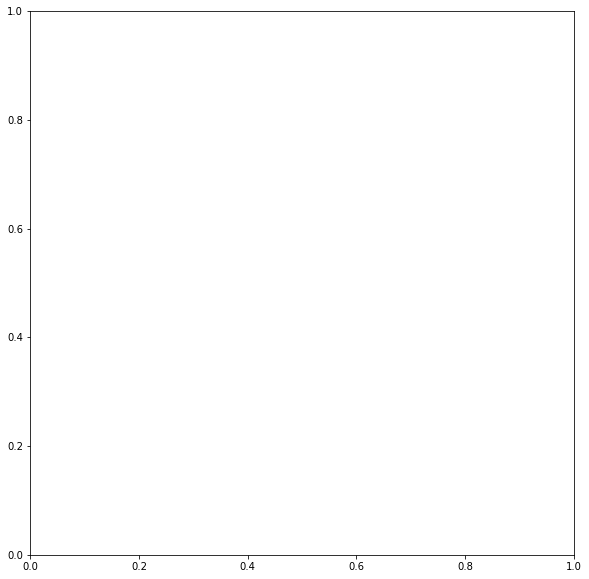

In [7]:
plt.figure(figsize=(12, 10))
plt.imshow(obs.squeeze(), cmap='gray')

In [ ]:
plt.figure(figsize=(12, 10))
plt.imshow(obs.squeeze(), cmap='jet')

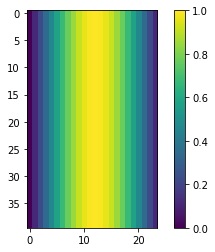

In [8]:
from scipy.stats import norm

x_all = np.arange(-1.2, 1.2, 0.1) # entire range of x, both in and out of spec
# mean = 0, stddev = 1, since Z-transform was calculated
y2 = norm.pdf(x_all,0,2/2)

y2 = np.interp(y2, (y2.min(), y2.max()), (0, 1))

tmp = np.zeros((40, 24))
for i in range(40):
    tmp[i] = y2

plt.imshow(tmp)
plt.colorbar()

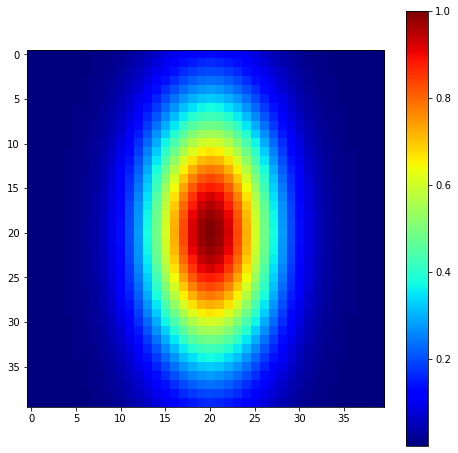

In [9]:
def twoD_Gaussian(x, y, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                            + c*((y-yo)**2)))
    return g.ravel()


x = np.linspace(0, 39, 40)
y = np.linspace(0, 39, 40)
x, y = np.meshgrid(x, y)

amplitude = 1
xo = 20
yo = 20
s_x = -5
s_y = 10

#create data
data = twoD_Gaussian(x, y, amplitude, xo, yo, s_x, s_y, 0, 0)

# plot twoD_Gaussian data generated above
plt.figure(figsize=(8, 8))
plt.imshow(data.reshape(40, 40), cmap='jet')
plt.colorbar()


In [3]:
ray.init()

2021-01-26 15:52:12,481	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.178.60',
 'raylet_ip_address': '192.168.178.60',
 'redis_address': '192.168.178.60:6379',
 'object_store_address': '/tmp/ray/session_2021-01-26_15-52-11_924519_1707033/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-26_15-52-11_924519_1707033/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-01-26_15-52-11_924519_1707033',
 'metrics_export_port': 47767,
 'node_id': 'fbb9d705a2552ca853f836148cae734d74df159f'}

In [4]:
#ModelCatalog.register_custom_model(
#    "my_model", VisionNetwork)

config = {
    "env": ScoutingDiscreteTask,  # or "corridor" if registered above
    "env_config": {
        "corridor_length": 5,
    },
    # Use GPUs iff `RLLIB_NUM_GPUS` env var set to > 0.

    "num_gpus": 1,
    "num_workers": 1,  # parallelism
    "model": {
        "fcnet_hiddens": [256, 128]
    }
    #"model": {
    #    "dim": 40,
    #    "conv_filters": [[16, [3, 3], 2], [32, [3, 3], 2], [64, [3, 3], 2], [512, [5, 16], 1]]
    #}
    #"model": {
    #    "use_lstm": True,
    #    # Max seq len for training the LSTM, defaults to 20.
    #    "max_seq_len": 20,
    #    # Size of the LSTM cell.
    #    "lstm_cell_size": 256
    #}
}

stop = {
    #"training_iteration": 1,
    "timesteps_total": 100000
}

In [6]:
trainer = PPOTrainer(config=config)
policy = trainer.get_policy()


2021-01-25 21:38:42,098	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-01-25 21:38:42,099	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=3113370) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=3113370) Instructions for updating:
(pid=3113370) non-resource variables are not supported in the long term
(pid=3113370) [ERROR] [1611607125.367892, 0.000000]: NOT Initialising Simulation Physics Parameters
(pid=3113370) [WARN] [1611607125.370488, 0.000000]: Start Init ControllersConnection
(pid=3113370) [WARN] [1611607125.371146, 0.000000]: END Init ControllersConnection
2021-01-25 21:38:51,264	WARNING util.py:43 -- Install gputil for GPU system mo

(pid=3113370) None


In [7]:
print(policy.model.base_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 12)]         0                                            
__________________________________________________________________________________________________
fc_1 (Dense)                    (None, 256)          3328        observations[0][0]               
__________________________________________________________________________________________________
fc_value_1 (Dense)              (None, 256)          3328        observations[0][0]               
__________________________________________________________________________________________________
fc_2 (Dense)                    (None, 128)          32896       fc_1[0][0]                       
______________________________________________________________________________________________

In [15]:
#ray.tune.run(PPOTrainer, config=config, stop=stop, checkpoint_freq=1, checkpoint_at_end=True)

Trial name,status,loc
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,


(pid=3113369) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=3113369) Instructions for updating:
(pid=3113369) non-resource variables are not supported in the long term
(pid=3113369) 2021-01-26 06:32:37,063	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=3113369) 2021-01-26 06:32:37,063	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=3113371) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=3113371) Instructions for updating:
(pid=3113371) non-reso

(pid=3113369) None
(pid=3113371) None
Result for PPO_ScoutingDiscreteTask_e4643_00000:
  custom_metrics: {}
  date: 2021-01-26_06-36-36
  done: false
  episode_len_mean: 53.80821917808219
  episode_reward_max: -92.79065921589513
  episode_reward_mean: -98.30140472610407
  episode_reward_min: -101.98332086546421
  episodes_this_iter: 73
  episodes_total: 73
  experiment_id: 4fd798fb8b014314b30afa9ee1f6a89e
  hostname: workstation
  info:
    learner:
      default_policy:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 1.392870545387268
        entropy_coeff: 0.0
        kl: 0.010542325675487518
        model: {}
        policy_loss: -0.010539914481341839
        total_loss: 4583.1474609375
        vf_explained_var: 1.4218591786629986e-05
        vf_loss: 4583.15673828125
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 192.168.178.60
  num_healthy_workers: 1
  off_policy_estimator: {}
  per

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,1,230.598,4000,-98.3014,-92.7907,-101.983,53.8082


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,2,462.332,8000,-98.2902,-92.7286,-101.251,51.92


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,3,687.551,12000,-98.5091,-92.7444,-102.512,53.49


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,4,900.199,16000,-98.2404,-91.0479,-102.104,58.94


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,5,1106.97,20000,-98.5189,-84.4644,-104.744,64.3


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,6,1298.86,24000,-98.5013,-84.4644,-105.041,76.73


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,7,1478.59,28000,-97.9081,-82.4376,-105.041,95.97


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,8,1654.18,32000,-96.9987,-82.4376,-105.041,109.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,9,1827.85,36000,-96.0541,-82.4376,-105.04,123.74


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,10,1990.84,40000,-93.9328,114.331,-106.943,140.36


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,11,2156.12,44000,-93.5003,114.331,-106.943,148.28


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,12,2316.77,48000,-93.3671,114.331,-106.943,168.14


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,13,2474.88,52000,-91.0207,115.107,-106.943,186.16


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,14,2632.22,56000,-88.5531,115.575,-106.943,206.86


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,15,2794.87,60000,-85.7616,117.456,-106.817,209.55


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,16,2957.93,64000,-83.3965,117.456,-104.491,215.82


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,17,3116.41,68000,-80.6415,117.456,-104.491,227.06


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,18,3275.23,72000,-78.4942,118.757,-104.491,224.13


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,19,3433.56,76000,-73.7879,118.757,-104.491,227.17


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,20,3588.42,80000,-69.8819,118.757,-107.184,233.22


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,21,3746.23,84000,-72.4675,118.757,-107.184,237.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,22,3896.31,88000,-69.8619,118.757,-107.184,256.83


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,23,4047.45,92000,-69.4806,118.757,-107.184,276.74


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,24,4199.95,96000,-65.2419,118.757,-107.184,281.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,25,4355.33,100000,-64.8136,118.757,-107.184,286.52


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,26,4515.52,104000,-63.1856,118.641,-107.184,287.52


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,27,4670.35,108000,-58.7781,118.641,-102.926,292.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,28,4822.05,112000,-58.5476,118.723,-102.926,299.81


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,29,4972.4,116000,-57.8293,118.723,-102.926,317.13


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,30,5125.52,120000,-55.9527,118.723,-105.183,310.27


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,31,5278.59,124000,-47.9396,118.77,-105.183,303.41


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,32,5429.11,128000,-49.9944,118.77,-105.183,311.02


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,33,5580.23,132000,-47.6572,118.77,-105.183,324.85


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,34,5733.5,136000,-51.378,118.77,-105.183,333.89


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,35,5885.29,140000,-50.9427,118.77,-105.183,347.57


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,36,6035.03,144000,-56.8328,118.77,-105.183,354.47


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,37,6189.22,148000,-52.6281,118.77,-105.183,352.34


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,38,6340.88,152000,-46.8033,118.77,-105.183,345.91


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,39,6494.36,156000,-42.5355,118.77,-102.185,353.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,40,6644.08,160000,-50.3079,118.769,-102.185,358.2


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,41,6796.32,164000,-46.2927,118.769,-102.185,350.35


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,42,6956.03,168000,-46.347,118.769,-102.185,351.76


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,43,7121.19,172000,-44.0156,118.769,-102.185,363.67


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,44,7276.55,176000,-37.738,118.769,-102.185,361.23


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,45,7430.56,180000,-31.8462,118.769,-102.185,347.15


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,46,7580.67,184000,-27.8184,118.769,-102.185,357.29


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,47,7733.54,188000,-33.8391,118.736,-101.61,355.99


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,48,7885.75,192000,-27.3578,118.759,-101.61,359.23


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,49,8035.64,196000,-15.2319,118.759,-101.61,354.73


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,50,8186.61,200000,-8.97491,118.759,-101.61,359.76


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,51,8337.58,204000,-2.8408,118.759,-101.61,356.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,52,8491.36,208000,3.43089,118.759,-101.61,350.24


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,53,8641.89,212000,5.73355,118.759,-101.61,353.69


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,54,8790.43,216000,12.0478,118.759,-101.61,366.44


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,55,8943.41,220000,14.0954,118.759,-101.61,356.59


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,56,9097.36,224000,22.0783,118.774,-102.384,356.28


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,57,9248.1,228000,13.5969,118.774,-102.384,356.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,58,9398.02,232000,13.7725,118.774,-102.384,356.05


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,59,9550.75,236000,17.9111,118.774,-102.384,357


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,60,9703.16,240000,15.6651,118.774,-102.384,349.33


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,61,9855.07,244000,21.6597,118.774,-102.384,358.71


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,62,10015.3,248000,25.7002,118.774,-102.384,357.25


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,63,10171.9,252000,21.4583,118.774,-102.384,346.54


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,64,10327.1,256000,23.5653,118.774,-102.384,348.78


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,65,10479.6,260000,25.6925,118.77,-100.784,345.67


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,66,10628.7,264000,36.2841,118.77,-100.784,352.88


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,67,10781.6,268000,34.1922,118.77,-101.709,353.33


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,68,10932.6,272000,36.2946,118.77,-101.709,356.28


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,69,11084.1,276000,40.4249,118.77,-101.709,360.91


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,70,11233.7,280000,40.5679,118.77,-101.709,364.12


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,71,11385.9,284000,34.4972,118.769,-101.792,367.26


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,72,11538.1,288000,40.3517,118.769,-101.792,370.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,73,11691.9,292000,42.4641,118.769,-101.792,368.81


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,74,11859.3,296000,44.4966,118.769,-101.792,370.2


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,75,12014.2,300000,42.4283,118.766,-101.792,371.31


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,76,12172,304000,39.9928,118.766,-101.792,368.26


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,77,12323.2,308000,42.0225,118.766,-101.792,370.72


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,78,12475.9,312000,44.0518,118.765,-101.792,372.88


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,79,12625.9,316000,41.8014,118.765,-101.792,376.81


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,80,12778.7,320000,47.5327,118.775,-101.792,371.29


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,81,12932.8,324000,41.4506,118.775,-101.061,362.85


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,82,13083.1,328000,41.4656,118.775,-101.061,373.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,83,13235.7,332000,41.1839,118.775,-101.162,380.21


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,84,13395.3,336000,38.7821,118.778,-101.401,370.24


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,85,13548.1,340000,36.3332,118.778,-101.401,367.11


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,86,13699.7,344000,36.4498,118.778,-101.401,371.76


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,87,13851.3,348000,34.213,118.778,-101.835,371.97


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,88,14011,352000,34.1037,118.778,-101.835,363.77


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,89,14181.9,356000,38.4704,118.778,-101.835,372.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,90,14356.5,360000,34.1511,118.778,-101.835,369.88


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,91,14526.3,364000,29.8321,118.781,-101.835,356.97


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,92,14698.8,368000,34.4691,118.781,-101.835,354.34


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,93,14868,372000,34.6555,118.781,-101.835,355.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,94,15035,376000,41.2964,118.781,-101.835,367.27


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,95,15202.3,380000,41.2298,118.781,-101.835,361.88


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,96,15374.1,384000,35.1362,118.781,-101.402,358.96


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,97,15548.6,388000,26.8248,118.781,-101.214,347.44


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,98,15718.9,392000,22.8696,118.781,-102.045,343.76


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,99,15892.4,396000,22.9529,118.781,-102.045,341.43


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,100,16059.8,400000,25.0705,118.778,-102.045,345.38


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,101,16234.4,404000,26.7334,118.778,-104.34,346.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,102,16410,408000,9.71525,118.778,-104.34,319.66


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,103,16575.1,412000,-1.30267,118.771,-109.226,321.62


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,104,16749.1,416000,-3.96455,118.767,-109.226,313.49


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,105,16900.1,420000,-6.08838,118.767,-109.226,319.31


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,106,17047.5,424000,-12.68,118.767,-115.317,336.8


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,107,17208.3,428000,-19.7,118.767,-115.558,355.92


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,108,17354.5,432000,-20.0498,118.767,-116.202,369.98


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,109,17499.7,436000,-26.7414,118.766,-116.202,407.22


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,110,17652.1,440000,-35.452,118.766,-116.202,401.03


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,111,17793.2,444000,-37.7238,118.766,-116.202,419.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,112,17943.2,448000,-50.2228,118.766,-116.202,452.25


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,113,18098.4,452000,-56.3905,118.766,-116.202,454.26


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,114,18256.1,456000,-51.7412,118.761,-116.202,440.49


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,115,18418.5,460000,-60.0445,118.776,-116.202,421.3


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,116,18569.2,464000,-59.6262,118.776,-116.202,385.29


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,117,18725.8,468000,-63.1154,118.776,-108.471,352.16


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,118,18872.3,472000,-62.9368,118.776,-108.471,326.62


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,119,19012.5,476000,-62.9368,118.776,-108.471,326.62


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,120,19154.6,480000,-63.3055,118.776,-137.279,404.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,121,19295.2,484000,-63.3055,118.776,-137.279,404.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,122,19435,488000,-63.3055,118.776,-137.279,404.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,123,19579.5,492000,-63.8853,118.776,-151.122,532.18


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,124,19733.9,496000,-59.4994,118.776,-151.122,480.44


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,125,19885.4,500000,-61.4417,118.776,-151.122,493.21


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,126,20030.6,504000,-58.9953,118.776,-151.122,501.28


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,127,20170.8,508000,-58.9953,118.776,-151.122,501.28


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,128,20314.5,512000,-61.3798,118.776,-151.122,586.96


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,129,20455.8,516000,-61.3762,118.776,-151.122,588.81


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,130,20605,520000,-63.3841,118.776,-151.122,649.58


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,131,20776.6,524000,-60.8884,118.776,-151.122,669.64


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,132,20944.9,528000,-58.1424,118.776,-151.122,684.37


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,133,21109.2,532000,-55.6343,118.776,-151.122,685.7


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,134,21266.4,536000,-57.0177,118.776,-151.122,705.6


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,135,21424.1,540000,-48.7464,118.776,-151.122,707.35


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,136,21578.2,544000,-49.4984,118.776,-116.293,499.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,137,21730,548000,-51.4027,118.776,-116.293,500.39


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,138,21881.9,552000,-47.2626,118.776,-116.293,507.41


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,139,22033.1,556000,-48.5879,118.767,-106.056,364.02


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,140,22187.4,560000,-52.6342,118.767,-106.056,360.39


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,141,22336.8,564000,-54.6764,118.767,-106.056,365.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,142,22490.6,568000,-56.4827,118.767,-106.056,364.31


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,143,22643.1,572000,-50.4915,118.767,-106.056,357.31


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,144,22795.6,576000,-54.4369,118.767,-106.056,365.91


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,145,22947.2,580000,-54.527,118.767,-106.056,372.02


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,146,23101.1,584000,-50.1079,118.767,-101.445,370.27


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,147,23255.5,588000,-54.8496,118.767,-101.445,354.93


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,148,23409.9,592000,-53.2758,118.767,-101.445,344.66


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,149,23560.8,596000,-47.1173,118.767,-102.126,353.35


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,150,23713.4,600000,-43.3177,118.767,-102.126,350.1


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,151,23865.3,604000,-43.509,118.767,-102.126,353.23


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,152,24017.4,608000,-47.6096,118.767,-102.126,360.96


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,153,24174,612000,-50.1932,118.771,-102.126,349.39


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,154,24325.9,616000,-42.0788,118.771,-102.126,348.49


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,155,24482.9,620000,-42.1271,118.771,-102.126,344.85


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,156,24637.7,624000,-40.4301,118.771,-102.126,337.65


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,157,24802.1,628000,-36.4108,118.771,-102.126,338.75


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,158,24958.3,632000,-42.342,118.771,-101.797,341.1


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,159,25113.4,636000,-39.8449,118.771,-101.797,345.79


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,160,25267.5,640000,-40.0346,118.771,-101.311,338.35


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,161,25420.3,644000,-40.1088,118.758,-101.311,344.67


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,162,25573.4,648000,-43.9851,118.758,-101.311,347.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,163,25727.6,652000,-43.6458,118.727,-101.311,348


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,164,25879.3,656000,-39.3206,118.757,-101.027,357.75


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,165,26029.3,660000,-32.5666,118.757,-101.027,371.32


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,166,26181.3,664000,-38.8829,118.757,-100.805,374.8


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,167,26341.6,668000,-32.6125,118.757,-100.805,378.94


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,168,26497.6,672000,-32.9035,118.757,-101.705,372.93


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,169,26653.6,676000,-32.904,118.757,-101.705,369.65


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,170,26806.9,680000,-28.5666,118.775,-101.705,365.02


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,171,26959.1,684000,-24.3187,118.775,-101.705,371.65


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,172,27111.3,688000,-18.0615,118.775,-105.251,379.76


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,173,27262.3,692000,-13.6635,118.775,-105.251,385.97


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,174,27413.9,696000,-18.0141,118.775,-105.251,384.23


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,175,27573.5,700000,-19.759,118.775,-105.251,384.39


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,176,27729.6,704000,-19.7747,118.775,-105.251,381.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,177,27882.5,708000,-17.4684,118.775,-105.251,386.2


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,178,28032.9,712000,-19.5746,118.778,-105.251,393.63


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,179,28185.9,716000,-17.3232,118.778,-105.251,391.97


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,180,28338.7,720000,-23.7094,118.778,-105.251,391.65


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,181,28492.8,724000,-30.136,118.778,-105.251,385.77


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,182,28643.4,728000,-28.2429,118.778,-101.981,384.82


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,183,28798,732000,-34.4066,118.778,-102.333,379.46


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,184,28950.3,736000,-36.6655,118.778,-102.333,374.79


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,185,29102.4,740000,-42.8473,118.778,-102.333,373.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,186,29255.2,744000,-40.6681,118.778,-102.333,375.52


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,187,29405.4,748000,-38.7348,118.778,-102.333,379.75


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,188,29556.7,752000,-40.9193,118.772,-102.973,377.7


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,189,29708.8,756000,-36.6884,118.772,-102.973,377.54


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,190,29860.7,760000,-38.7575,118.772,-102.975,379.06


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,191,30013,764000,-38.6521,118.772,-102.975,380.02


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,192,30164.5,768000,-42.4295,118.772,-102.975,381.18


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,193,30317,772000,-48.6368,118.768,-102.975,391.25


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,194,30475.7,776000,-40.388,118.768,-102.975,391.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,195,30634.1,780000,-46.4854,118.768,-102.975,388.16


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,196,30787.7,784000,-48.6933,118.772,-102.975,385.55


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,197,30940.9,788000,-51.0057,118.772,-102.975,374.19


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,198,31093,792000,-50.674,118.772,-102.975,379.79


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,199,31244.1,796000,-52.734,118.772,-103.75,390.97


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,200,31395.1,800000,-52.8473,118.772,-103.75,386.35


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,201,31542.8,804000,-50.6962,118.772,-103.75,394.9


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_e4643_00000,RUNNING,192.168.178.60:3113369,202,31694.5,808000,-53.1116,118.772,-103.75,398.92


KeyboardInterrupt: 

In [9]:
results = []
for i in range(300):
    result = trainer.train()
    results.append(result)

    if i % 5 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)

    if i % 20 == 0:
        print(pretty_print(result))


(pid=3113370) 2021-01-25 21:38:52,380	WARNING deprecation.py:29 -- DeprecationWarning: `env_index` has been deprecated. Use `episode.env_id` instead. This will raise an error in the future!
(pid=3113370) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/ray/rllib/policy/tf_policy.py:850: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
(pid=3113370) Instructions for updating:
(pid=3113370) Prefer Variable.assign which has equivalent behavior in 2.X.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
checkpoint saved at /home/dschori/ray_results/PPO_ScoutingDiscreteTask_2021-01-25_21-38-42t2fe461o/checkpoint_1/checkpoint-1
custom_metrics: {}
date: 2021-01-25_21-42-24
done: false
episode_len_mean: 58.46268656716418
episode_reward_max: -93.31922394531603
episode_reward_mean: -98.34086626783368
episode_reward_min: -101.87034592068791
episodes_this_iter: 67
episodes_total: 67
experiment_id: 7fae3e80ca2a43bbb11958a087576346
hostname: workstation
info:
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 1.4172453880310059
      entropy_coeff: 0.0
      kl: 0.009320477955043316
      model: {}
      policy_loss: -0.01237860880792141
      total_loss: 4126.09814453125
      vf_explained_var: -7.066034413583111e-06
      vf_loss: 4126.10888671875
  num_steps_sampled: 4000
  num_steps_trained: 4000
iterations_since_restore: 1
node_ip: 1

KeyboardInterrupt: 

In [11]:
def train(stop_criteria, config):
    """
    Train an RLlib PPO agent using tune until any of the configured stopping criteria is met.
    :param stop_criteria: Dict with stopping criteria.
        See https://docs.ray.io/en/latest/tune/api_docs/execution.html#tune-run
    :return: Return the path to the saved agent (checkpoint) and tune's ExperimentAnalysis object
        See https://docs.ray.io/en/latest/tune/api_docs/analysis.html#experimentanalysis-tune-experimentanalysis
    """
    analysis = ray.tune.run(PPOTrainer, config=config,
                            stop=stop_criteria,
                            checkpoint_freq=1,
                            checkpoint_at_end=True)
    # list of lists: one list per checkpoint; each checkpoint list contains 1st the path, 2nd the metric value
    checkpoints = analysis.get_trial_checkpoints_paths(trial=analysis.get_best_trial('episode_reward_mean', mode='max'),
                                                       metric='episode_reward_mean',
                                                       )
    # retriev the checkpoint path; we only have a single checkpoint, so take the first one
    checkpoint_path = checkpoints[0][0]
    return checkpoint_path, analysis

def load(checkpoint_path, config):
    """
    Load a trained RLlib agent from the specified path. Call this before testing a trained agent.
    :param path: Path pointing to the agent's saved checkpoint (only used for RLlib agents)
    """
    agent = PPOTrainer(config=config)
    agent.restore(checkpoint_path)
    return agent

def test(agent, env):
    """Test trained agent for a single episode. Return the episode reward"""
    # instantiate env class

    # run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()
    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward

    return episode_reward

In [6]:
checkpoint_path, analysis = train(stop_criteria=stop, config=config)

Trial name,status,loc
PPO_ScoutingDiscreteTask_17c34_00000,RUNNING,


(pid=1707211) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1707211) Instructions for updating:
(pid=1707211) non-resource variables are not supported in the long term
(pid=1707211) 2021-01-26 15:52:24,185	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=1707211) 2021-01-26 15:52:24,185	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=1707213) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1707213) Instructions for updating:
(pid=1707213) non-reso

(pid=1707211) None
(pid=1707213) None
Result for PPO_ScoutingDiscreteTask_17c34_00000:
  custom_metrics: {}
  date: 2021-01-26_15-56-31
  done: true
  episode_len_mean: 51.467532467532465
  episode_reward_max: -93.34017255756284
  episode_reward_mean: -98.97171318466
  episode_reward_min: -101.41004032678605
  episodes_this_iter: 77
  episodes_total: 77
  experiment_id: 84ed0f4990c941418572603a47229e4b
  hostname: workstation
  info:
    learner:
      default_policy:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 1.3943806886672974
        entropy_coeff: 0.0
        kl: 0.00637952471151948
        model: {}
        policy_loss: -0.008917012251913548
        total_loss: 4439.38427734375
        vf_explained_var: 8.779187737673055e-06
        vf_loss: 4439.39111328125
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 192.168.178.60
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_17c34_00000,RUNNING,192.168.178.60:1707211,1,237.678,4000,-98.9717,-93.3402,-101.41,51.4675


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_17c34_00000,TERMINATED,,1,237.678,4000,-98.9717,-93.3402,-101.41,51.4675


In [12]:
agent = load(checkpoint_path=checkpoint_path, config=config)

episode_reward = test(agent=agent, env=env)
episode_reward

2021-01-26 15:58:28,089	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-01-26 15:58:28,090	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=1707218) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1707218) Instructions for updating:
(pid=1707218) non-resource variables are not supported in the long term
(pid=1707218) [ERROR] [1611673111.620246, 0.000000]: NOT Initialising Simulation Physics Parameters
(pid=1707218) [WARN] [1611673111.628420, 0.000000]: Start Init ControllersConnection
(pid=1707218) [WARN] [1611673111.629552, 0.000000]: END Init ControllersConnection
2021-01-26 15:58:37,797	WARNING util.py:43 -- Install gputil for GPU system mo

(pid=1707218) None


-100.93780072577